In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [7]:
# Path to the dataset
image_folder = "/content/drive/MyDrive/cats_vs_dogs/cats_vs_dogs"

# Parameters
image_size = (224, 224)  # Resize images to 224x224
images = []
labels = []

In [8]:

# Load the data
for filename in os.listdir(image_folder):
    if filename.startswith('cat'):
        label = 0
    elif filename.startswith('dog'):
        label = 1
    else:
        continue

    img_path = os.path.join(image_folder, filename)
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(label)

In [9]:
# Convert lists to numpy arrays
images = np.array(images, dtype='float32')
labels = np.array(labels, dtype='int32')

In [10]:
# Normalize the images
images /= 255.0

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Training data shape: {train_images.shape}, Training labels shape: {train_labels.shape}')
print(f'Testing data shape: {test_images.shape}, Testing labels shape: {test_labels.shape}')


Training data shape: (1600, 224, 224, 3), Training labels shape: (1600,)
Testing data shape: (400, 224, 224, 3), Testing labels shape: (400,)


In [11]:
from tensorflow.keras import layers, models, losses, Model

def inception(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):

    path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)

    path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

    return tf.concat([path1, path2, path3, path4], axis=3)

In [19]:
# Define the Inception model
inp = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inp)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(1, activation='sigmoid')(aux1)

x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(1, activation='sigmoid')(aux2)

x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=[out, aux1, aux2])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_118 (Conv2D)         (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_26 (MaxPooli  (None, 55, 55, 64)           0         ['conv2d_118[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_119 (Conv2D)         (None, 55, 55, 64)           4160      ['max_pooling2d_26[0][0]

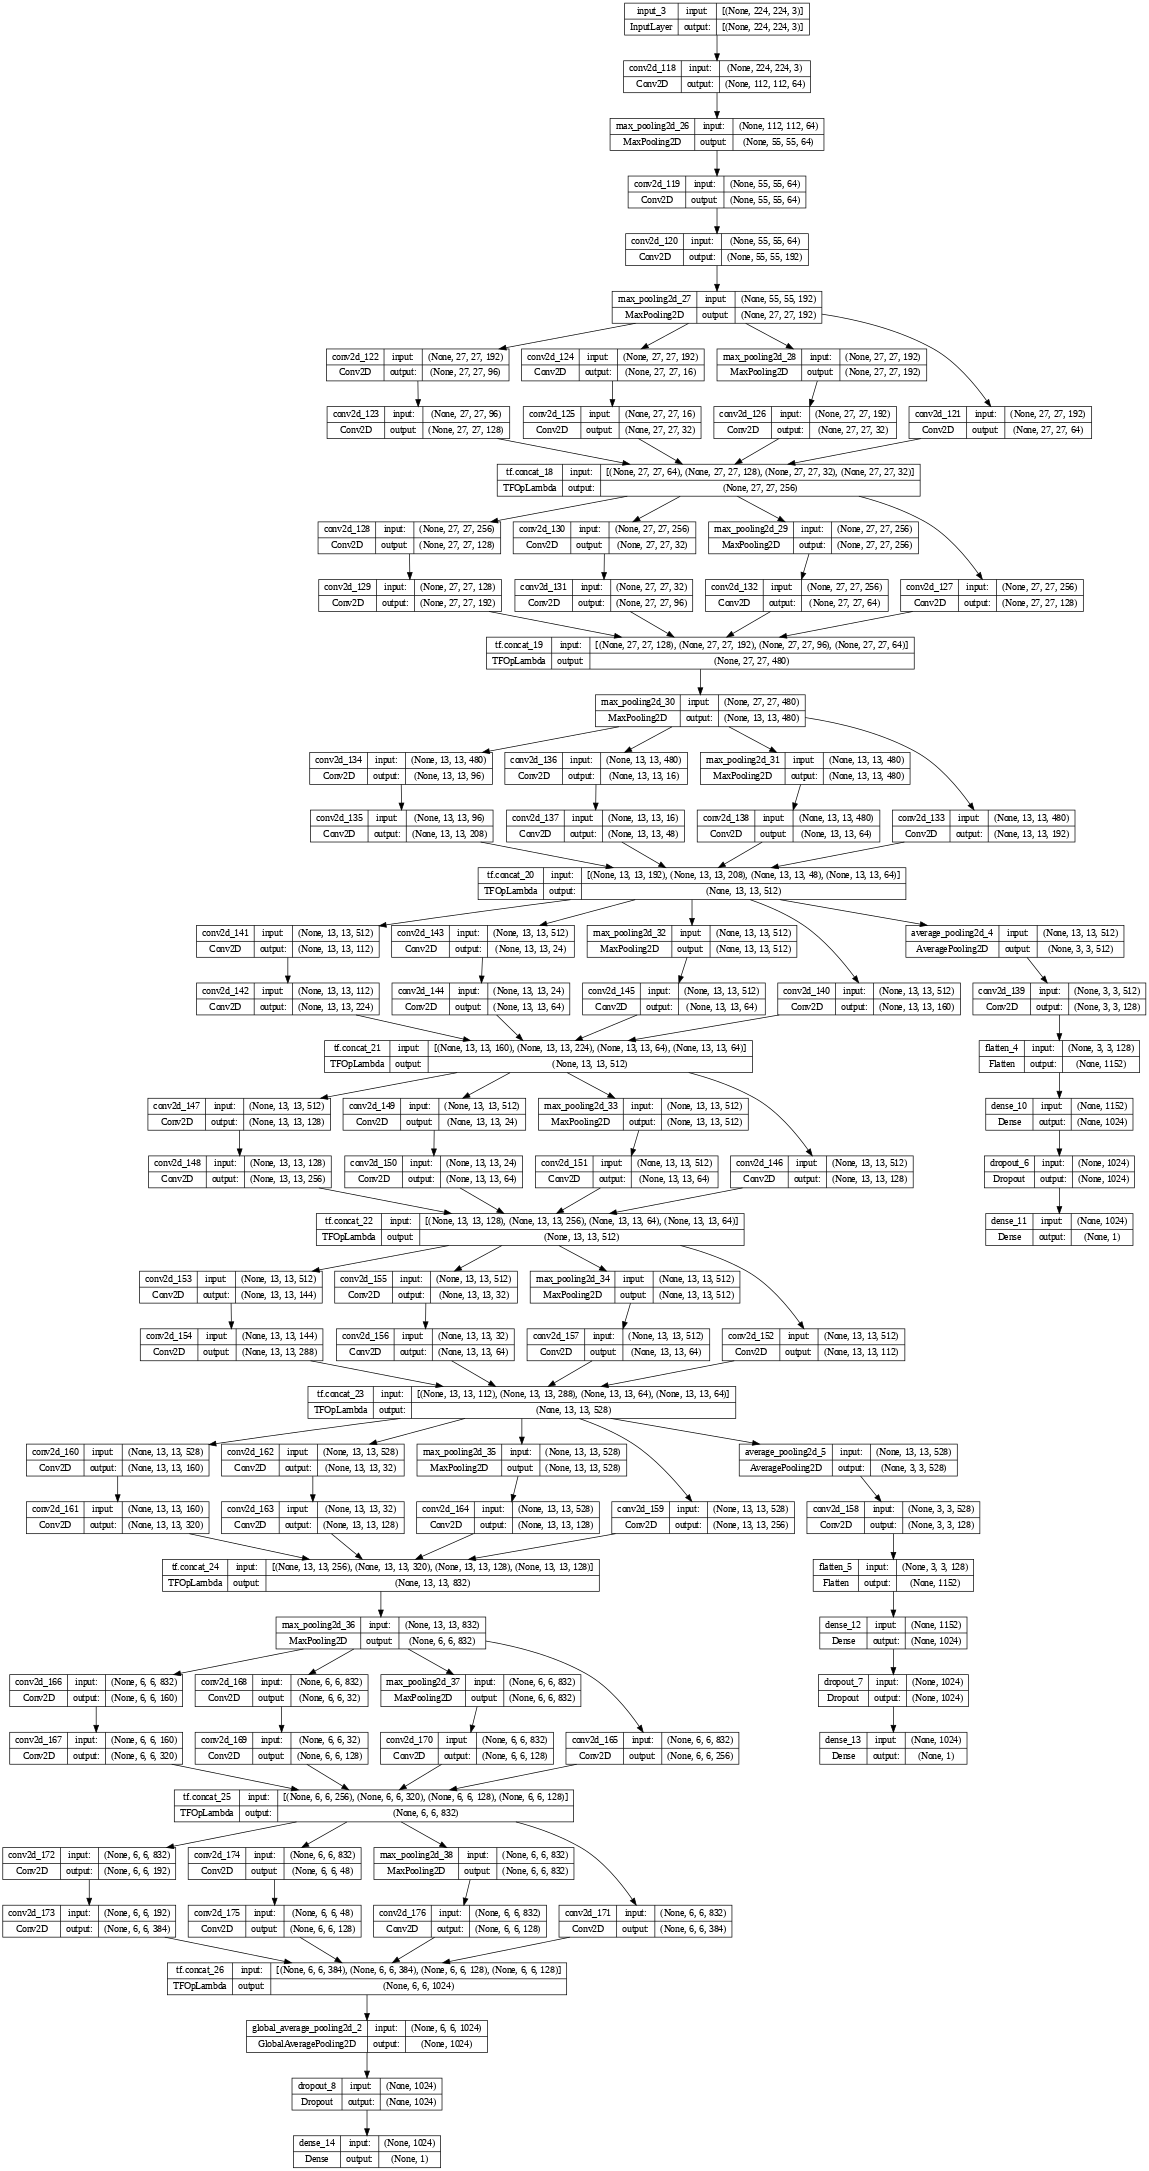

In [20]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True , dpi=50)

In [21]:
# Compile the model
model.compile(optimizer='adam',
              loss=[losses.binary_crossentropy,
                    losses.binary_crossentropy,
                    losses.binary_crossentropy],
              loss_weights=[1, 0.3, 0.3],
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, [train_labels, train_labels, train_labels],
                    validation_data=(test_images, [test_labels, test_labels, test_labels]),
                    batch_size=32, epochs=10)


Epoch 1/10
50/50 [==============================] - 46s 243ms/step - loss: 1.1268 - dense_14_loss: 0.7077 - dense_11_loss: 0.6999 - dense_13_loss: 0.6971 - dense_14_accuracy: 0.4925 - dense_11_accuracy: 0.5069 - dense_13_accuracy: 0.4906 - val_loss: 1.1091 - val_dense_14_loss: 0.6931 - val_dense_11_loss: 0.6933 - val_dense_13_loss: 0.6932 - val_dense_14_accuracy: 0.5025 - val_dense_11_accuracy: 0.5025 - val_dense_13_accuracy: 0.4975
Epoch 2/10
50/50 [==============================] - 6s 115ms/step - loss: 1.1095 - dense_14_loss: 0.6934 - dense_11_loss: 0.6935 - dense_13_loss: 0.6935 - dense_14_accuracy: 0.4906 - dense_11_accuracy: 0.4925 - dense_13_accuracy: 0.4719 - val_loss: 1.1090 - val_dense_14_loss: 0.6931 - val_dense_11_loss: 0.6931 - val_dense_13_loss: 0.6931 - val_dense_14_accuracy: 0.5025 - val_dense_11_accuracy: 0.5025 - val_dense_13_accuracy: 0.5025
Epoch 3/10
50/50 [==============================] - 6s 112ms/step - loss: 1.1093 - dense_14_loss: 0.6933 - dense_11_loss: 0.693

In [22]:
# Evaluate the model on the test set
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 42ms/step - loss: 1.1092 - dense_14_loss: 0.6932 - dense_11_loss: 0.6934 - dense_13_loss: 0.6932 - dense_14_accuracy: 0.4975 - dense_11_accuracy: 0.4975 - dense_13_accuracy: 0.4975


[1.1092238426208496,
 0.693236768245697,
 0.6934260725975037,
 0.6931973099708557,
 0.4975000023841858,
 0.4975000023841858,
 0.4975000023841858]

keep changin the names in the plot

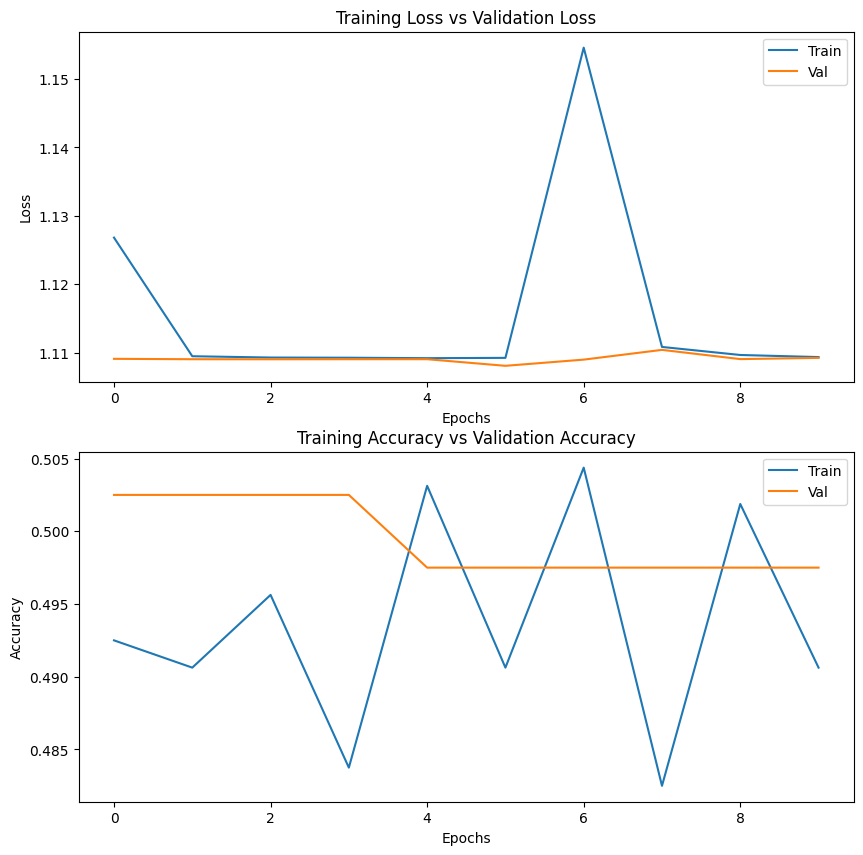

In [24]:
# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['dense_14_accuracy'])
axs[1].plot(history.history['val_dense_14_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

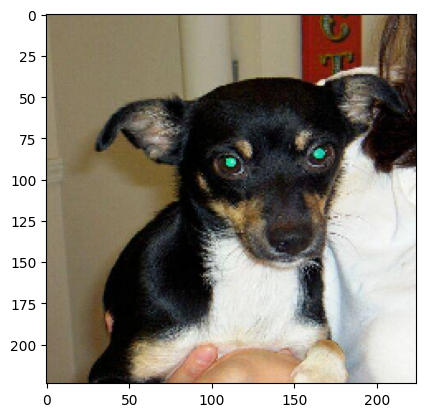

1/1 [==============================] - 0s 24ms/step
Predicted: Dog


In [36]:
import random
idx2 = random.randint(0, len(test_labels))
plt.imshow(test_images[idx2, :])
plt.show()

# Predict the class for a sample image
idx2 = 42  # Example index
y_pred = model.predict(test_images[idx2, :].reshape(1, 224, 224, 3))

# Select the main inception output (typically the last one)
main_output = y_pred[-1]

# Convert to NumPy array and apply threshold
main_output = np.array(main_output) > 0.5

# Check the predicted class and print the result
if main_output[0] == 0:
    print("Predicted: Cat")
else:
    print("Predicted: Dog")